## Import Libraries and load cifar10 dataset.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, random_split

import numpy as np
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
#import additional libraries if needed

In [2]:
def load_cifar10_data(batch_size):
# load both training and test datasets, and transform them to tensors.
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

    return trainloader, testloader, trainset

In [3]:
batch_size = 32
trainloader, testloader, trainset = load_cifar10_data(batch_size)
classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:03<00:00, 54474519.80it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
train_size = int(0.8 * len(trainset))
test_size = len(trainset) - train_size
train_dataset, validation_dataset = random_split(trainset, [train_size, test_size])

validationloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [5]:
# Check the dimensions of a batch:
for images, labels in trainloader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([32, 3, 32, 32])
Image label dimensions: torch.Size([32])


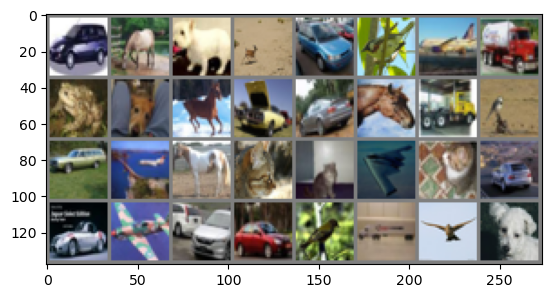

car   horse dog   deer  car   bird  plane truck frog  dog   horse car   car   horse truck bird  car   plane horse cat   cat   plane cat   car   car   plane car   car   bird  truck bird  dog  


In [6]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Section 1: Define your CNN model
Define your output layer, optimizer and loss criterion

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        #TODO: Define your CNN here
        # self.conv1 = nn.Conv2d(3, 6, 5)
        # self.pool = nn.MaxPool2d(2, 2)
        # ...
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(in_features=128 * 4 * 4, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=10)
        self.relu = nn.ReLU()

    def forward(self, x):
        #TODO: Compute the forward pass here
        # x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [8]:
#create model
model = CustomCNN()

## Section 2: Define optimizer and loss criterion

In [9]:
# Hyperparameters
random_seed = 42
learning_rate = 0.001
num_epochs = 8
folds = 10

np.random.seed(random_seed)

# optimizer
optimizer = torch.optim.SGD(model.parameters(), learning_rate, momentum=0.9, weight_decay=1e-4)

# loss
loss = nn.CrossEntropyLoss()
fold_size = len(trainset)//folds

In [10]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', DEVICE)
# Set my pretrained model to be run on GPU
model = model.to(DEVICE)

Device: cuda:0


In [11]:
# Helper function to compute the accuracy
def compute_accuracy(resnet, trainloader):
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for images, labels in trainloader:
            outputs = resnet(images)
            _, predictions = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            total_correct += (predictions == labels).sum().item()

    accuracy = 100 * total_correct / total_samples
    return accuracy

In [12]:
# Helper function to compute the loss over epochs
def compute_epoch_loss(resnet, trainloader):
    criterion = nn.CrossEntropyLoss()
    loss = 0.0
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    resnet.to(device)
    
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = resnet(images)
        batch_loss = criterion(outputs, labels)
        loss += batch_loss.item()
        
    return loss / len(trainloader)

In [13]:
def train_model(trainloader, test_loader, num_epochs, model, optimizer, loss_fn):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    epoch_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
            total_loss += loss.item()
        
        epoch_loss = total_loss / len(trainloader)
        epoch_accuracy = 100 * correct_predictions / total_samples
        epoch_accuracies.append(epoch_accuracy)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
        
    model.eval()
    correct_predictions = 0
    total_samples = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

        test_accuracy = 100 * correct_predictions / total_samples
        print(f"Test Accuracy: {test_accuracy:.2f}%\n")
    train_accuracy = sum(epoch_accuracies) / num_epochs
        
    return train_accuracy, test_accuracy

## Section 3: Test your model

In [14]:
dataiter = iter(testloader)
images, labels = next(dataiter)

In [15]:
import os

validation_accuracies  = []
training_accuracies  = []
kf = KFold(n_splits=folds, shuffle=True, random_state=42)
indices = list(range(len(train_dataset)))

for fold, (train_indices, test_indices) in enumerate(kf.split(indices)):
    print(f'Fold {fold+1}')
    
    train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    validation_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

    cpu_cores = os.cpu_count()

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, sampler=train_sampler, num_workers=cpu_cores//2, pin_memory=True)
    validation_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, sampler=validation_sampler, num_workers=cpu_cores//2, pin_memory=True)

    train_accuracy, validation_accuracy = train_model(train_loader, validation_loader, num_epochs, model, optimizer, loss)
    validation_accuracies .append(validation_accuracy)
    training_accuracies .append(train_accuracy)

average_train_accuracy = np.mean(training_accuracies )
average_validation_accuracy = np.mean(validation_accuracies )

print(f"Accuracy of the network on the train images: {average_train_accuracy:.2f}%")
print(f"Accuracy of the network on the 10000 test images: {average_validation_accuracy:.2f}%")
print("Cross-validation complete")

Fold 1
Epoch [1/8], Loss: 1.5334, Accuracy: 43.71%
Epoch [2/8], Loss: 1.1620, Accuracy: 58.39%
Epoch [3/8], Loss: 1.0014, Accuracy: 64.72%
Epoch [4/8], Loss: 0.9067, Accuracy: 67.99%
Epoch [5/8], Loss: 0.8384, Accuracy: 70.53%
Epoch [6/8], Loss: 0.7808, Accuracy: 72.38%
Epoch [7/8], Loss: 0.7239, Accuracy: 74.28%
Epoch [8/8], Loss: 0.6871, Accuracy: 75.71%
Test Accuracy: 73.25%

Fold 2
Epoch [1/8], Loss: 0.6705, Accuracy: 76.51%
Epoch [2/8], Loss: 0.6256, Accuracy: 77.99%
Epoch [3/8], Loss: 0.5917, Accuracy: 79.24%
Epoch [4/8], Loss: 0.5561, Accuracy: 80.65%
Epoch [5/8], Loss: 0.5204, Accuracy: 81.71%
Epoch [6/8], Loss: 0.4928, Accuracy: 82.62%
Epoch [7/8], Loss: 0.4659, Accuracy: 83.61%
Epoch [8/8], Loss: 0.4284, Accuracy: 84.73%
Test Accuracy: 81.00%

Fold 3
Epoch [1/8], Loss: 0.4462, Accuracy: 84.41%
Epoch [2/8], Loss: 0.4068, Accuracy: 85.68%
Epoch [3/8], Loss: 0.3806, Accuracy: 86.55%
Epoch [4/8], Loss: 0.3575, Accuracy: 87.48%
Epoch [5/8], Loss: 0.3358, Accuracy: 88.36%
Epoch [6/